In [2]:
print("hello world")

hello world


In [3]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor,ToPILImage, Normalize, Resize, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torch.hub import load_state_dict_from_url
from stepbystep.v3 import StepByStep

2024-03-14 22:51:12.630404: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 22:51:12.879650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 22:51:12.879706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 22:51:12.893617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 22:51:12.933179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 22:51:12.934042: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Pre-Trained Model

In [4]:
alex = alexnet(weights=None)
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
from torchinfo import summary
summary(alex,input_size=(16,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 1000]                --
├─Sequential: 1-1                        [16, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [16, 64, 55, 55]          23,296
│    └─ReLU: 2-2                         [16, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [16, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [16, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [16, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [16, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [16, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [16, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [16, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [16, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [16, 256, 13, 13]        

### Average Pooling  
Returns the tensor with desired shape regardless of the input shape

In [6]:
result1=F.adaptive_avg_pool2d(input=torch.randn(16,32,32),output_size=(6,6))
result2=F.adaptive_avg_pool2d(input=torch.randn(16,32,32),output_size=(6,6))
result1.shape,result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

### Loading Weights

In [7]:
# URL for alexnet pretrained weights


In [8]:
from torchvision.models import AlexNet_Weights
alex=alexnet(weights=AlexNet_Weights.DEFAULT)

In [9]:
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# Model freezing
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad=False

In [11]:
freeze_model(alex)

### Top of the model

In [12]:
alex.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
#replacing the top of the model
alex.classifier[6]=nn.Linear(4096,3)

In [14]:
# Check for gradient calculation requirement of output layer
for name,param in alex.named_parameters():
    if param.requires_grad==True:
        print(name)

classifier.6.weight
classifier.6.bias


In [15]:
summary(alex,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           (23,296)
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          (307,392)
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          (663,936)
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          (884,992)
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13] 

In [16]:
# Model config
torch.manual_seed(17)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_alex=optim.Adam(alex.parameters(),lr=3e-4)

In [17]:
# Data prep
normalizer=Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
composer=Compose(transforms=[Resize(256),CenterCrop(224),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)

In [18]:
# Model Training
sbs_alex=StepByStep(alex,multi_loss_fn,optimizer_alex)
sbs_alex.set_loaders(train_loader,val_loader)
sbs_alex.train(3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
StepByStep.loader_apply(val_loader,sbs_alex.correct)

tensor([[110, 124],
        [124, 124],
        [124, 124]])

In [20]:
StepByStep.loader_apply(train_loader,sbs_alex.correct)

tensor([[838, 840],
        [839, 840],
        [840, 840]])

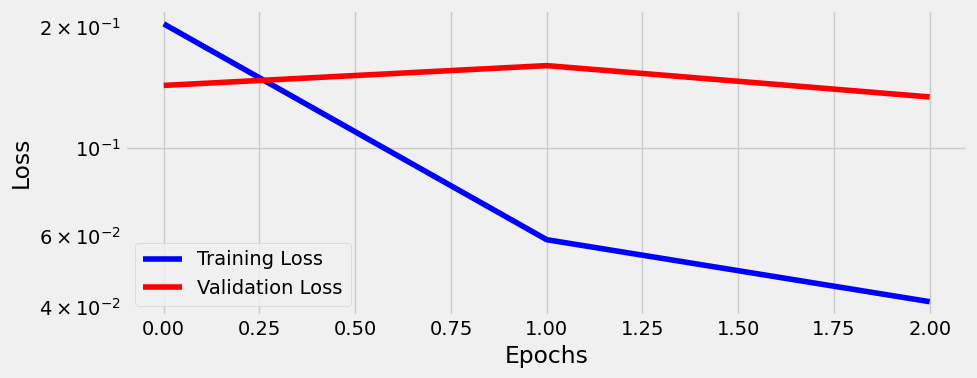

In [21]:
sbs_alex.plot_losses()

## Generating a Dataset of features

In [23]:
# Removing the Top layer
alex.classifier[6]=nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


In [30]:
from tqdm.notebook import tqdm

def preprocessed_dataset(model,loader,device=None):
    if device is None:
        device=next(model.parameters()).device
    features=None
    labels=None

    for i,(x,y) in tqdm(enumerate(loader)):
        model.eval()
        output=model(x.to(device))

        if i==0:
            features=output.detach().cpu()
            labels=y.cpu()

        else:
            features=torch.cat([features,output.detach().cpu()])
            labels=torch.cat([labels,y.cpu()])

    dataset=TensorDataset(features,labels)
    return dataset

In [31]:
# Data preparation
train_preproc=preprocessed_dataset(alex,train_loader)
val_preproc=preprocessed_dataset(alex,val_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [44]:
!pwd

/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch


Save pre processed dataset

In [45]:
torch.save(train_preproc.tensors,'rps_preproc.pth')
torch.save(val_preproc.tensors,'rps_val_preproc.pth')

## Auxilary Classifiers (Side Heads)  
Side heads attached to intermediate parts of the model try to perform callsification independently from main classifier. 

In [57]:
# Loading pretrained inceptionv3 and replacing top layers
from torchvision.models import Inception_V3_Weights
model=inception_v3(weights=Inception_V3_Weights)
freeze_model(model)

torch.manual_seed(42)
model.AuxLogits.fc=nn.Linear(768,3)
model.fc=nn.Linear(2048,3)

/home/anushka/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/anushka/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [04:52<00:00, 373kB/s] 


In [61]:
summary(model,input_size=(16,3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [16, 3]                   2,560,003
├─BasicConv2d: 1-1                       [16, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [16, 32, 149, 149]        (864)
│    └─BatchNorm2d: 2-2                  [16, 32, 149, 149]        (64)
├─BasicConv2d: 1-2                       [16, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [16, 32, 147, 147]        (9,216)
│    └─BatchNorm2d: 2-4                  [16, 32, 147, 147]        (64)
├─BasicConv2d: 1-3                       [16, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [16, 64, 147, 147]        (18,432)
│    └─BatchNorm2d: 2-6                  [16, 64, 147, 147]        (128)
├─MaxPool2d: 1-4                         [16, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [16, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [16, 80, 73, 73]

In [62]:
def inception_loss(outputs,labels):
    try:
        main,aux=outputs
    except ValueError:
        main=outputs
        aux=None
        loss_aux=0
    
    multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
    loss_main=multi_loss_fn(main,labels)

    if aux is not None:
        loss_aux=multi_loss_fn(aux,labels)
    return loss_main+0.4*loss_aux

In [63]:
# model config
optimizer_model=optim.Adam(model.parameters(),lr=3e-4)
sbs_incep=StepByStep(model,inception_loss,optimizer_model)

We do not pre processed the dataset since preprocessed_dataset() cannot handle multiple outputs

In [67]:
# Data prep
normalizer=Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
composer=Compose(transforms=[Resize(299),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)

In [68]:
# Model Training
sbs_incep.set_loaders(train_loader,val_loader)
sbs_incep.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
sbs_incep.loader_apply(val_loader,sbs_incep.correct)

tensor([[104, 124],
        [124, 124],
        [112, 124]])

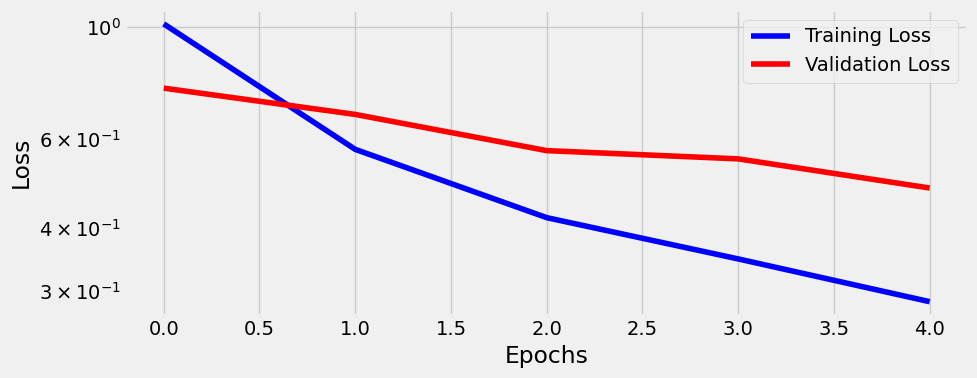

In [70]:
sbs_incep.plot_losses()

We can convert an image to gray scale using 1x1 convolution

In [77]:
scissors=Image.open("rps/scissors/scissors01-000.png")
image=ToTensor()(scissors)[:3,:,:].view(1,3,300,300)

weights=torch.tensor([0.2126,0.7152,0.0722]).view(1,3,1,1)
convolved=F.conv2d(input=image,weight=weights)

converted=ToPILImage()(convolved[0])
grayscale=scissors.convert('L')

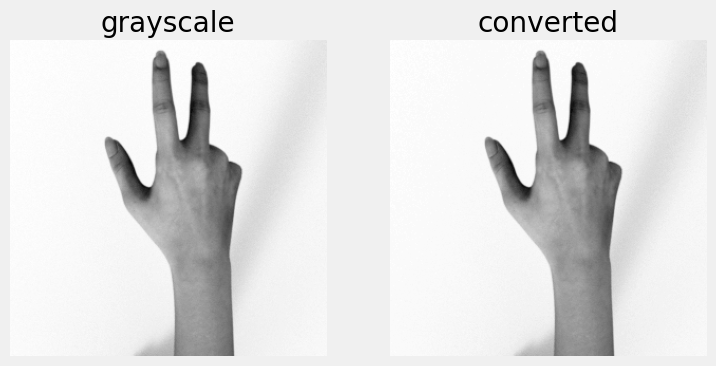

In [78]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,2,figsize=(8,5))
axes[0].imshow(grayscale,cmap='gray')
axes[0].set_title("grayscale")
axes[0].grid(False)
axes[0].axis('off')

axes[1].imshow(converted,cmap='gray')
axes[1].set_title("converted")
axes[1].grid(False)
axes[1].axis('off')
plt.show()


### Inception module

In [83]:
class Inception(nn.Module):
    def __init__(self,in_channels):
        super(Inception,self).__init__()
        # in_channels@HxW ->2@HxW
        self.branch1x1_1=nn.Conv2d(in_channels,2,kernel_size=1)
        # in_channels@HxW ->2@HxW -> 3@HxW
        self.branch5x5_1=nn.Conv2d(in_channels,2,kernel_size=1)
        self.branch5x5_2=nn.Conv2d(2,3,kernel_size=5,padding=2)
        # in_channel@HxW ->2@HxW ->3@HxW
        self.branch3x3_1=nn.Conv2d(in_channels,2,kernel_size=1)
        self.branch3x3_2=nn.Conv2d(2,3,kernel_size=3,padding=1)
        # in_channel@HxW ->in_channel@HxW -> 1@HxW
        self.branch_pool_1=nn.AvgPool2d(kernel_size=3,stride=1,padding=1)
        self.branch_pool_2=nn.Conv2d(in_channels,2,kernel_size=1)
    
    def forward(self,x):
        # produces 2 channels
        branch1x1=self.branch1x1_1(x)
        # produces 3 channels
        branch5x5=self.branch5x5_1(x)
        branch5x5=self.branch5x5_2(branch5x5)
        # produces 3 channels
        branch3x3=self.branch3x3_1(x)
        branch3x3=self.branch3x3_2(branch3x3)
        # produce 2 channels
        branch_pool=self.branch_pool_1(x)
        branch_pool=self.branch_pool_2(branch_pool)

        # concatenate all channels together @10
        outputs=torch.cat([branch1x1,branch5x5,branch3x3,branch_pool]) 
        return outputs

In [97]:
my_inception=Inception(3)
summary(my_inception,input_size=(3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
Inception                                [10, 299, 299]            --
├─Conv2d: 1-1                            [2, 299, 299]             8
├─Conv2d: 1-2                            [2, 299, 299]             8
├─Conv2d: 1-3                            [3, 299, 299]             153
├─Conv2d: 1-4                            [2, 299, 299]             8
├─Conv2d: 1-5                            [3, 299, 299]             57
├─AvgPool2d: 1-6                         [3, 299, 299]             --
├─Conv2d: 1-7                            [2, 299, 299]             8
Total params: 242
Trainable params: 242
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 1.07
Forward/backward pass size (MB): 10.01
Params size (MB): 0.00
Estimated Total Size (MB): 11.09

In [98]:
inception=Inception(in_channels=3)
output=inception(image.squeeze())
output.unsqueeze(0).shape

torch.Size([1, 10, 300, 300])

## Batch Normalization (**use after activation)

* Normalization layers are essential to prevent **internal covariance shift**(Difrrent distribution of activation values in different layers)  
* BN values have `zero mean `and `unit std`  
* It computes std, mean for each mini batch.  
* It may perform affine transformation (scaling and adding a constant to the output)

$$
\text{standardized } x_i = \frac{x_i - \bar{X}}{\sigma_X + \epsilon}
$$

`set bias=False in preceding layer`

$$
\text{batch normed } x_i = b + w \cdot \text{standardized } x_i
$$

$$
\text{batch normed } x_i =  \text{standardized } x_i \cdot \gamma+\beta
$$

### Keep track of running statistics

In [126]:
torch.manual_seed(23)
dummy_points=torch.randn((200,2))+torch.randn((200,2))*2
dummy_labels=torch.randint(2,(200,1))

dummy_dataset=TensorDataset(dummy_points,dummy_labels)
dummy_loader=DataLoader(dummy_dataset,batch_size=64,shuffle=True)


In [127]:
iterator=iter(dummy_loader)
batch1=next(iterator)
batch2=next(iterator)
batch3=next(iterator)

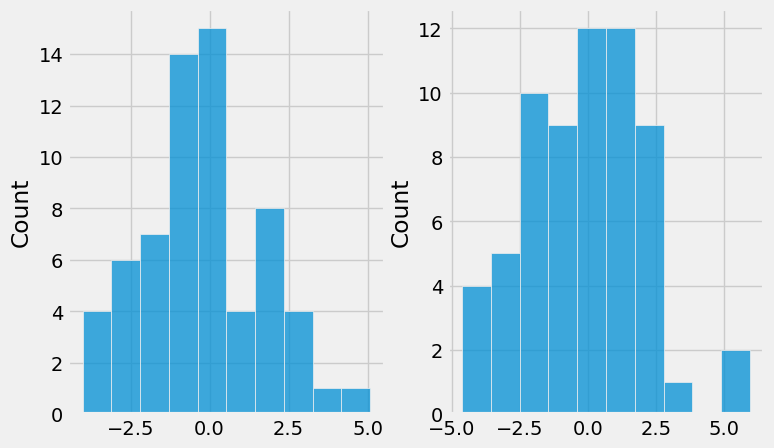

In [128]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

sns.histplot(batch1[0][:, 0], bins=10, ax=axes[0])
sns.histplot(batch1[0][:, 1], bins=10, ax=axes[1])
plt.show()

In [129]:
mean1,var1=batch1[0].mean(axis=0),batch1[0].var(axis=0)
mean1,var1

(tensor([-0.2283, -0.2116]), tensor([3.7427, 4.7615]))

In [130]:
batch_normalizer=nn.BatchNorm1d(num_features=2,affine=False,momentum=None)
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

In [131]:
norm1=batch_normalizer(batch1[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([-0.2283, -0.2116])),
             ('running_var', tensor([3.7427, 4.7615])),
             ('num_batches_tracked', tensor(1))])

In [133]:
norm1.mean(axis=0),norm1.var(axis=0)

(tensor([1.4901e-08, 3.3528e-08]), tensor([1.0159, 1.0159]))

The `running variance is` **unbiased**, but actual standardization of the data points in a mini batch uses biased variance

In [134]:
norm1.var(axis=0,unbiased=False)

tensor([1.0000, 1.0000])

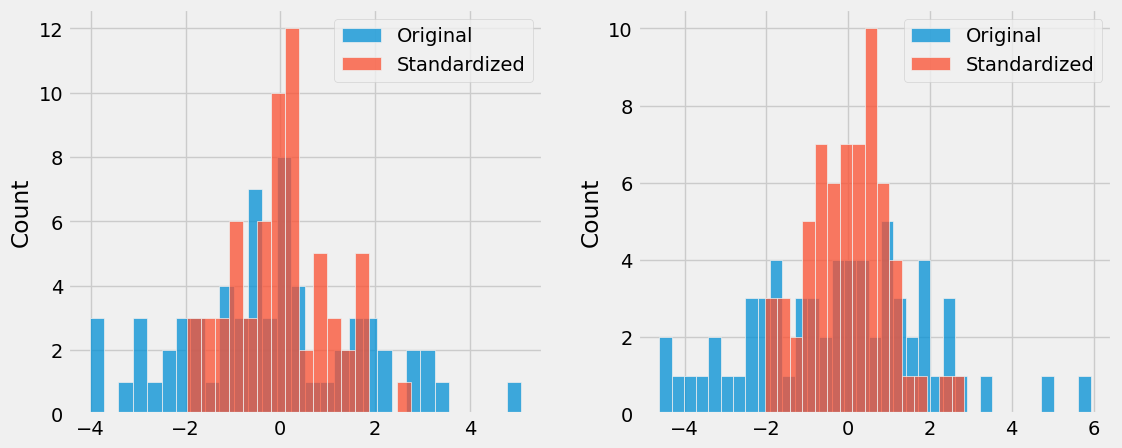

In [149]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(batch1[0][:, 0], binwidth=0.3, ax=axes[0], label='Original')
sns.histplot(norm1[:, 0], binwidth=0.3, ax=axes[0], label='Standardized')

sns.histplot(batch1[0][:, 1], binwidth=0.3, ax=axes[1], label='Original')
sns.histplot(norm1[:, 1], binwidth=0.3, ax=axes[1], label='Standardized')

axes[0].legend()
axes[1].legend()

plt.show()

Batch Normalization dont turn inputs into `Normal Distribution`

In [150]:
# feed 2nd mini batch
norm2=batch_normalizer(batch2[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([-0.1930, -0.0222])),
             ('running_var', tensor([4.1655, 4.5009])),
             ('num_batches_tracked', tensor(2))])

Both running mean and running var are average over mini batches

In [153]:
mean2,var2=batch2[0].mean(axis=0),batch2[0].var(axis=0) # unbiased variance
running_mean,running_var=(mean1+mean2)/2,(var1+var2)/2
running_mean,running_var

(tensor([-0.1930, -0.0222]), tensor([4.1655, 4.5009]))

### Evaluation phase

In [154]:
batch_normalizer.eval()
norm3=batch_normalizer(batch3[0])
norm3.mean(axis=0),norm3.var(axis=0,unbiased=False)

(tensor([0.1350, 0.1450]), tensor([1.0134, 1.2981]))

### Momentum  
Exponential weighted moving averages instead of average

$$
\text{EWMA}_t(\alpha,x) = \alpha \cdot x_t + (1-\alpha) \cdot \text{EWMA}_{t-1}(\alpha,x)
$$

In [158]:
batch_normalizer_mom=nn.BatchNorm1d(num_features=2,affine=False,momentum=0.1)
batch_normalizer_mom.state_dict() # values at t=t-1

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

Ruuning statistics will be barely budged

In [159]:
normed1_mom=batch_normalizer_mom(batch1[0])
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([-0.0228, -0.0212])),
             ('running_var', tensor([1.2743, 1.3761])),
             ('num_batches_tracked', tensor(1))])

In [160]:
running_mean=torch.zeros(1,2)
running_mean=0.1*batch1[0].mean(axis=0)+(1-0.1)*running_mean
running_mean

tensor([[-0.0228, -0.0212]])

## BatchNorm2d

BN2d standardize pixels

In [162]:
torch.manual_seed(39)
dummy_images=torch.randn((200,3,10,10))
dummy_labels=torch.randint(2,(200,1))
dummy_dataset=TensorDataset(dummy_images,dummy_labels)
dummy_loader=DataLoader(dummy_dataset,batch_size=64,shuffle=True)
iterator=iter(dummy_loader)

batch1=next(iterator)
batch1[0].shape

torch.Size([64, 3, 10, 10])

In [163]:
batch_normalizer=nn.BatchNorm2d(num_features=3,affine=False,momentum=None)
normed1=batch_normalizer(batch1[0])

print(normed1.mean(axis=[0,2,3]),normed1.var(axis=[0,2,3],unbiased=False))

tensor([-8.9407e-10,  1.6019e-09, -5.9605e-10]) tensor([1.0000, 1.0000, 1.0000])


* Batch Normalization improves model training by making the loss surface smoother  
* By reducing internal covarinace shift, ***vanishing gradients***  problem can be solved

## Residual connections  

to avoid the problem of vanishing gradients

* Non linearities making it hard for the model to learn

In [178]:
torch.manual_seed(23)
dummy_points=torch.randn((100,1))
dummy_dataset=TensorDataset(dummy_points,dummy_points)
dummy_loader=DataLoader(dummy_dataset,batch_size=16,shuffle=True)

In [179]:
class Dummy(nn.Module):
    def __init__(self):
        super(Dummy,self).__init__() # call to the parent class's init method
        self.linear=nn.Linear(1,1)
        self.activation=nn.ReLU()

    def forward(self,x):
        x=self.linear(x)
        x=self.activation(x)
        return x
    

In [180]:
torch.manual_seed(555)
dummy_model=Dummy()
dummy_optimizer=optim.SGD(dummy_model.parameters(),lr=0.1)
dummy_loss_fn=nn.MSELoss(reduction='mean')


In [181]:
dummy_sbs=StepByStep(dummy_model,dummy_loss_fn,dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

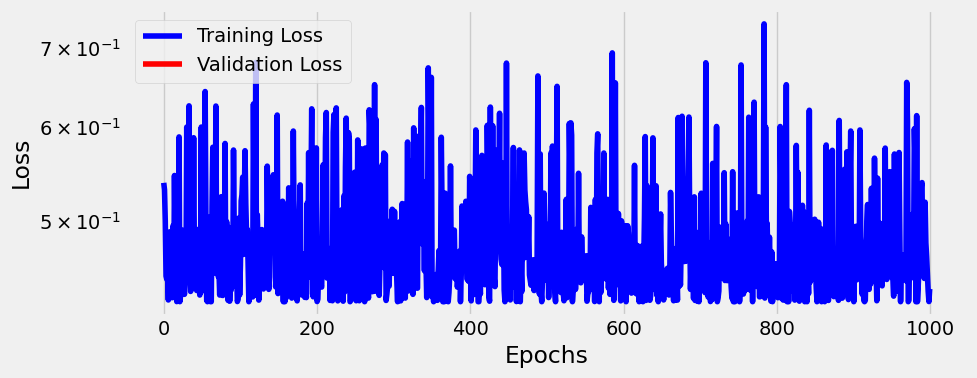

In [182]:
dummy_sbs.plot_losses()

In [185]:
dummy_points[:5]

tensor([[-0.9012],
        [ 0.5656],
        [-0.4882],
        [ 0.7507],
        [ 0.5893]])

ReLU can Only return positive values

In [188]:
np.concatenate([dummy_points[:5].numpy(),dummy_sbs.predict(dummy_points[:5].numpy())],axis=1)

array([[-0.9012059 ,  0.        ],
       [ 0.56559485,  0.56559485],
       [-0.48822638,  0.        ],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

Lets add residual conncetion to the model

In [205]:
class Dummy(nn.Module):
    def __init__(self):
        super(Dummy,self).__init__() # call to the parent class's init method
        self.linear=nn.Linear(1,1)
        self.activation=nn.ReLU()

    def forward(self,x):
        identity=x
        x=self.linear(x)
        x=self.activation(x)
        return x+identity
    

In [206]:
torch.manual_seed(555)
dummy_model=Dummy()
dummy_optimizer=optim.SGD(dummy_model.parameters(),lr=0.01)
dummy_loss_fn=nn.MSELoss(reduction='mean')

dummy_sbs=StepByStep(dummy_model,dummy_loss_fn,dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

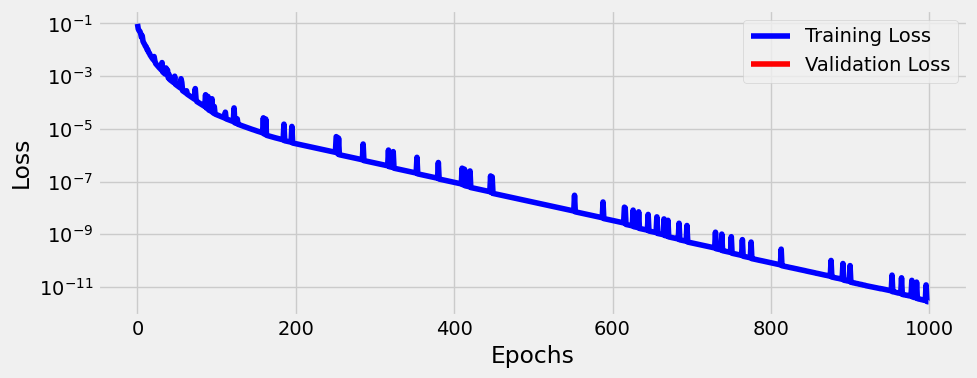

In [207]:
dummy_sbs.plot_losses()

In [208]:
dummy_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1488]])),
             ('linear.bias', tensor([-0.3325]))])

In [209]:
np.concatenate([dummy_points[:5].numpy(),dummy_sbs.predict(dummy_points[:5].numpy())],axis=1)

array([[-0.9012059 , -0.9012059 ],
       [ 0.56559485,  0.56559485],
       [-0.48822638, -0.48822638],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

In [236]:
np.concatenate([np.array([[100]]),dummy_sbs.predict(np.array([[100]]))],axis=1)

array([[100.        , 114.54716492]])

In [229]:
dummy_points.max().item() # Highest value in dataset

2.2346930503845215

In [230]:
np.abs(dummy_model.state_dict()["linear.bias"].item()/dummy_model.state_dict()["linear.weight"].item()) #  b/w value

2.2345754689441395

* Residual connetion enable models to skip non linearties when it is not benificial
* These shortcuts makes the loss surface smoother
* They provides shorter path for the gradients to travel back to the initial layers


## Residual Blocks

In [239]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU()

        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        
        self.downsample=None
        if out_channels!=in_channels:
            self.downsample=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
            
    def forward(self,x):
        identity=x
        # first; weight layer + activation
        out=self.conv1(x)
        out=self.relu(out)
        out=self.bn1(out)

        # second; weight layer + activation
        out=self.conv2(out)
        if self.downsample is not None:
            identity=self.downsample(identity)
        out=out+identity
        out=self.relu(out)
        return out
    




### Putting it all together

In [ ]:
# Data preparation
normalizer=Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
composer=Compose(transforms=[Resize(256),
                             CenterCrop(224),
                             ToTensor(),
                             normalizer])
train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

# Builds a loader of each set
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)